In [15]:
# pip install directly into notebook
%pip install sklearn
%pip install pandas
%pip install imbalanced-learn
%pip install seaborn
%pip install scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [16]:
import sklearn as sk
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold, cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neural_network import MLPRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from scipy.stats import ttest_1samp

In [17]:
# disable warning for chained assignment (not necessary but cleans up the project)
pd.options.mode.chained_assignment = None

In [18]:
# taken from kaggle example
class ReplaceZeroTransformer():
    """Eliminates Zero values from tempo columns and replace it 
       with the median or mean of non-zero values as specified.
       defaut is set to 'median'.
    """

    def __init__(self, method='median'):
        self.method = method

    def transform(self, X):
        if self.method == 'median':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].median()
        elif self.method == 'mean':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].mean()
        else:
            raise Exception("Method can be 'median' or 'mean' only!")
        return X

In [19]:
# Import track data
usecols = ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode','popularity', 'speechiness', 'tempo', 'valence']
dataset = pd.read_csv("data.csv", header = 0, usecols=usecols)

# Remove rows duplicated by ignoring some columns
dataset = dataset[~dataset.duplicated()==1]

# Normalize columns having values outside [0, 1]
scaler = MinMaxScaler()
# cols_to_normalize = ['duration_ms', 'key', 'loudness', 'popularity', 'tempo']
cols_to_normalize = ['duration_ms', 'loudness', 'tempo']
dataset[cols_to_normalize] = scaler.fit_transform(dataset[cols_to_normalize])

# print(dataset)

In [20]:
# # Data analysis
# # Commented out because it takes a while, and just produces graphs you've already seen before.
# # pair plots: https://seaborn.pydata.org/generated/seaborn.pairplot.html
# import seaborn as sb

# # Pairwise plots between each column in the data set excluding popularity, binary (mode and explicit) and discrete (key) features
# pair_plot_data = dataset.drop(columns=['mode', 'explicit', 'key', 'popularity'])
# sb.pairplot(pair_plot_data, corner=True)
# # There isn't a lot of direct correlation between any two property of a song

# # Correlation between each property and popularity
# sb.pairplot(dataset, x_vars=usecols, y_vars=['popularity'])
# # The proprties we have do not directly correlate with the popularity of a song

# # Analyze binary and discrete features (mode, explicit, key)
# sb.displot(data=dataset, x='mode')        # more songs are in major key
# sb.displot(data=dataset, x='explicit')    # most songs are non explicit, most likely do not need this feature
# sb.displot(data=dataset, x='key')         # somewhat even distribution of keys

# # Analyze features in relation to popularity; these graphs are not very useful
# sb.pairplot(dataset, y_vars=['mode', 'explicit', 'key'], x_vars=['popularity'])

# # Count non-continuous features
# non_explicit = dataset[dataset['explicit'] == 0].shape[0]
# major = dataset[dataset['mode'] == 1].shape[0]
# total_songs = dataset.shape[0]
# print(f"Non-Explicit songs / total songs = {non_explicit/total_songs}")
# print(f"Major key songs / total songs = {major/total_songs}")

# # Analyze range of popularity of songs given explicit = 0 or 1 and mode = 0 or 1
# sb.histplot(data=dataset, x="popularity", hue="explicit", multiple="dodge")
# # sb.histplot(data=dataset, x="popularity", hue="mode", multiple="dodge")    # similar shapes for both


In [21]:
# Further preprocessing

y = dataset.pop('popularity') # popularity is our class to predict
X_headers = list(dataset.columns.values)
X = dataset

# Create the under sampler
undersample = RandomUnderSampler(sampling_strategy='majority')

# apply the transform
X, y = undersample.fit_resample(X, y)

tempo_transformer = ReplaceZeroTransformer()
X = tempo_transformer.transform(X)

# need to scale after to treat the individual categories as their own class for the undersampling
y = y/100

In [22]:
# one hot encode the keys since they are a multiclass
ohe = OneHotEncoder(categories='auto', drop='first')

feature_arr = ohe.fit_transform(X[['key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X['key'].values))[1:]]
features = pd.DataFrame(feature_arr, columns = columns_key, index = X.index)
X = pd.concat([X, features], axis=1).drop(['key'], axis=1)

In [23]:
# Now divide our data into test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
# # Hyperparameter tuning
# # Commented out since we have found the ideal hyperparameters already
# # Set the parameters by cross-validation
# tuned_parameters = [
#     # {
#     #     'max_depth': np.arange(5, 15),
#     # },
#     {
#         'max_depth': np.arange(1, 20),
#         'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
#     },
#     {
#         'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
#         'max_leaf_nodes': np.arange(256, 324)
#     },
#     {
#         'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
#         'min_samples_split': np.arange(50, 700)
#     }
# ]

# # Available regression metrics are given here: https://scikit-learn.org/stable/modules/classes.html#regression-metric
# # https://stackoverflow.com/questions/42228735/scikit-learn-gridsearchcv-with-multiple-repetitions/42230764#42230764
# # ensure scikit is >0.18


# inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
# outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
# print("Tuning hyper-parameters begin!")
# print()

# # clf = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3)
# clf = HalvingGridSearchCV(tree.DecisionTreeRegressor(random_state=1), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3, random_state=1)
# print("Classifiers established, training data")
# print()

# clf.fit(X, y)
# non_nested_scores = clf.best_score_
# print("Best parameters found:", clf.best_params_)
# print("Score (mean squared):", -clf.best_score_)

# print("Running cross validation")
# print()
# clf.best_params_["random_state"] = 1
# # cross_val_raw_data = cross_validate(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3, return_estimator=True, return_train_score=True)
# clf = tree.DecisionTreeRegressor(**clf.best_params_)
# cv_score = cross_val_score(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3,  scoring='neg_mean_squared_error')
# print("Cross validation score (mean squared):", -cv_score.mean())

# clf.fit(X, y)

# print('Feature importances:')
# for i, col in enumerate(X.columns):
#     print(f'{col:18}: {clf.feature_importances_[i]:.3f}')

In [38]:
# Train a model with optimal hyperparams
kwargs = {'ccp_alpha': 3.9388e-05,'max_leaf_nodes': 238}
rgr = tree.DecisionTreeRegressor(**kwargs)
rgr.fit(X_train, y_train)
print(f"rmse: {mean_squared_error(y_test, rgr.predict(X_test), squared=False)}")


rmse: 0.15917359532816955


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

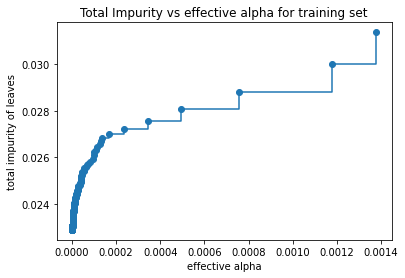

In [26]:
# All code beyond this point makes charts for use in our report

criteria = ["mse", "friedman_mse"] # didn't make a big difference
max_depth = 9 # found to result in best accuracy TODO: test over a range

clf = tree.DecisionTreeRegressor(criterion="mse", max_depth=max_depth)
#     clf = clf.fit(X_train, y_train)

# cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
# print(cross_val_score(clf, X_train, y_train, cv=cv))


# Following a tutorial on Cost Complexity Pruning https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

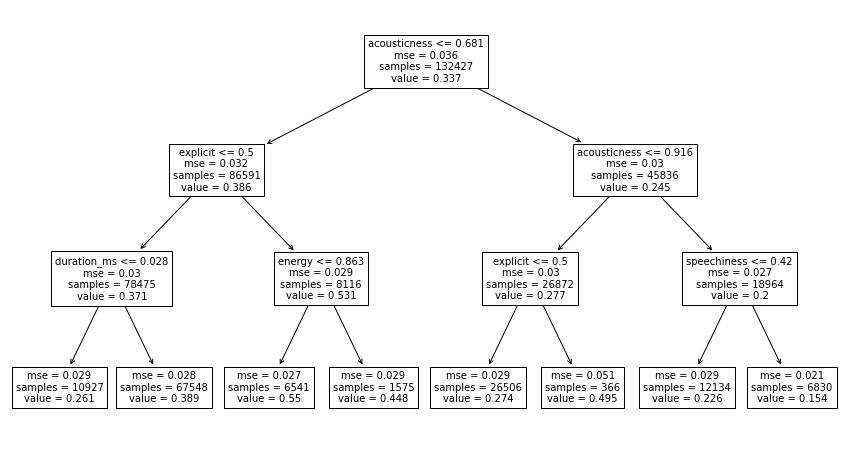

In [28]:
# Draw tree
clf = tree.DecisionTreeRegressor(ccp_alpha=3.9388E-05, max_depth= 3)
clf.fit(X,y)
# clf.get_depth()
plt.figure(figsize=(15,8))
tree.plot_tree(clf,  fontsize=10, feature_names=usecols)
plt.show()

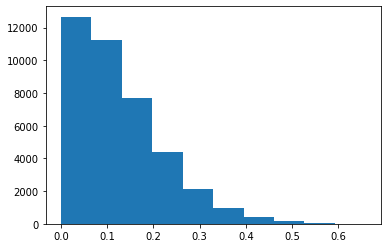

0.3372635586911679


In [29]:
my_tree = tree.DecisionTreeRegressor(ccp_alpha=3.9388E-05, min_samples_split= 238)
my_tree.fit(X_train, y_train)
a = my_tree.predict(X_test)
b = a - y_test
plt.hist(abs(b))
plt.show()
print(a.mean())
np.savetxt("foo.csv", a, delimiter=",")

In [30]:
# # p value testing
# # Warning - P value tests are long
# num_tests = 10
# tests_scores = []

# tuned_parameters = [
#     # {
#     #     'max_depth': np.arange(5, 15),
#     # },
#     {
#         'max_depth': np.arange(1, 20),
#         'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
#     },
#     {
#         'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
#         'max_leaf_nodes': np.arange(256, 324)
#     },
#     {
#         'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
#         'min_samples_split': np.arange(50, 700)
#     }
# ]

# inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
# outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
# print("Tuning hyper-parameters begin!")
# print()

# # clf = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3)
# clf = HalvingGridSearchCV(tree.DecisionTreeRegressor(random_state=1), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3, random_state=1)
# print("Classifiers established, training data")
# print()

# clf.fit(X, y)
# non_nested_scores = clf.best_score_
# print("Best parameters found:", clf.best_params_)
# print("Score (mean squared):", -clf.best_score_)

# print("Running cross validation")
# print()
# clf.best_params_["random_state"] = 1
# # cross_val_raw_data = cross_validate(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3, return_estimator=True, return_train_score=True)
# clf = tree.DecisionTreeRegressor(**clf.best_params_)
# cv_score = cross_val_score(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3,  scoring='neg_mean_squared_error')
# print("Cross validation score (mean squared):", -cv_score.mean())
# orig_score = -cv_score.mean()

# for i in range(num_tests):
#     np.random.shuffle(y)
#     tuned_parameters = [
#         # {
#         #     'max_depth': np.arange(5, 15),
#         # },
#         {
#             'max_depth': np.arange(1, 20),
#             'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
#         },
#         {
#             'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
#             'max_leaf_nodes': np.arange(256, 324)
#         },
#         {
#             'ccp_alpha' : np.append(0, np.linspace(0.000001, 0.0001, 50)),
#             'min_samples_split': np.arange(50, 700)
#         }
#     ]

#     inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
#     outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
#     print("Tuning hyper-parameters begin!")
#     print()

#     # clf = GridSearchCV(tree.DecisionTreeRegressor(), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3)
#     clf = HalvingGridSearchCV(tree.DecisionTreeRegressor(random_state=1), tuned_parameters, cv=inner_cv, scoring='neg_mean_squared_error', verbose=4, n_jobs=3, random_state=1)
#     print("Classifiers established, training data")
#     print()

#     clf.fit(X, y)
#     non_nested_scores = clf.best_score_
#     print("Best parameters found:", clf.best_params_)
#     print("Score (mean squared):", -clf.best_score_)

#     print("Running cross validation")
#     print()
#     clf.best_params_["random_state"] = 1
#     # cross_val_raw_data = cross_validate(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3, return_estimator=True, return_train_score=True)
#     clf = tree.DecisionTreeRegressor(**clf.best_params_)
#     cv_score = cross_val_score(clf, X=X, y=y, cv=outer_cv, verbose=4,  n_jobs=3,  scoring='neg_mean_squared_error')
#     print("Cross validation score (mean squared):", -cv_score.mean())
#     tests_scores.append(-cv_score.mean())
    
# tset, pval = ttest_1samp(tests_scores, orig_score)
# print("p-value", pval)